# Neural Networks Learning

## 1 Neural Network

Trough this excercise, the backpropagation algorithm for neural networks is developed and implemented to learn hand-written digit recognition problem.


### 1.1 Data visualization

There are 5000 training examples in *ex4data1.mat*, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This results in a 5000 by 400 matrix **X** where every row is a training example for a handwritten digit image.

In [1]:
import scipy.io as sio
from scipy.optimize import minimize, fmin_cg
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import style
style.use('ggplot')
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder

In [2]:
# MNIST dataset, load and visualization
dataset = sio.loadmat('ex4data1.mat')
print(dataset)
X = dataset['X']
y = dataset['y']
y[:500] = 0
print(f'X matrix shape: {X.shape}')
print(f'y vector shape: {y.shape}')

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011', '__version__': '1.0', '__globals__': [], 'X': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'y': array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)}
X matrix shape: (5000, 400)
y vector shape: (5000, 1)


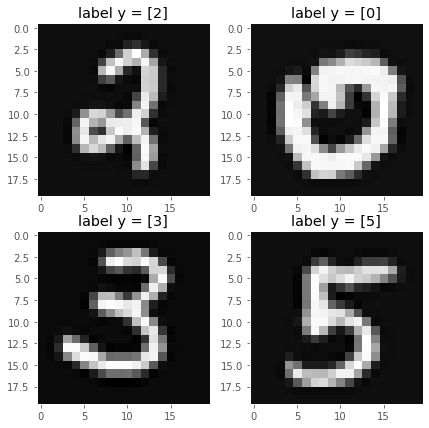

In [3]:
rand_indices = np.random.randint(low=0, high=X.shape[0], size=4)
plt.figure(figsize=(7,7))
for i, rand_index in enumerate(rand_indices):
    plt.subplot(2,2,i+1)
    plt.title(f'label y = {y[rand_index]}')
    plt.gray()
    plt.grid()
    plt.imshow(X[rand_index].reshape(20,20).T)

### 1.2 Model representation

To start with the feedforward algorithm, parameters theta 1 and theta 2 (weights between input and hidden layer, and hidden and output layer) are stored in *ex4weights.mat*.
![nn](nn.png)

In [4]:
# initial weights
weights = sio.loadmat('ex4weights.mat')
print(weights['__header__'])
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']
print(f'Theta1 shape: {Theta1.shape}')
print(f'Theta2 shape: {Theta2.shape}')

b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Oct 18 14:57:02 2011'
Theta1 shape: (25, 401)
Theta2 shape: (10, 26)


### 1.3 Feedforward and cost funtion

A neural network's cost function (without regularization) is defined as:
$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}[-y^{(i)}\log(h_{\theta}(x^{(i)})) - (1-y^{(i)})\log(1-h_{\theta}(x^{i}))]$$

where $h_{\theta}(x^{(i)})$ is computed as shown in Model representation figure and $ K $} is the total number of possible labels, in this case $ K = 10 $. 

In this case, where the neural network consists of 3 layer, term $h_{\theta}(x^{(i)})$ is the activation (output value) of the *k*-th output unit, $a_{k}^{(3)}$, where the output unit is calculated via feedforward algorithm as follows:
$$
z^{(2)} = \theta^{(1)} x
$$

where $x$ can be written as $x=a^{(1)}$,
$$
a^{(2)} = g(z^{(2)}) 
$$

$$
a_{0}^{2} = +1
$$

Finally, we have value for $z^{(3)}$:
$$
z^{(3)} = \theta^{(2)} a^{(2)}
$$

Output is then defined as:
$$
h_{\theta}(x) = a^{(3)} = g(z^{(3)})
$$
where $ g $ is sigmoid function defined as:

$$ 
g(z) = \frac{1}{1 + e^{-z}}.
$$

Also, note that y has to be encoded in a way that labels 0, 1, ..., 9 are vectors containing only values 0 or 1.

After the regularization is applied, cost function is defined as:
$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}[-y^{(i)}\log(h_{\theta}(x^{(i)})) - (1-y^{(i)})\log(1-h_{\theta}(x^{i}))] + + \frac{\lambda}{2m}[\sum_{j=1}^{25}\sum_{k=1}^{400}(\theta_{j,k}^{(1)})^2 + \sum_{j=1}^{10}\sum_{k=1}^{25}(\theta_{j,k}^{(2)})^2] $$

In [5]:
# architecture
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
nn_params = np.r_[Theta1.ravel(), Theta2.ravel()]

In [6]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def labelEncoder(y):
    # encode y to (5000, 10) sparse matrix
    enc = OneHotEncoder(categories='auto')
    return enc.fit_transform(y).toarray()

def feedforward(X, Theta1, Theta2):
    # number of training examples
    m = X.shape[0]
    
    # input layer
    X_bias = np.concatenate((np.ones((m, 1)), X), axis=1)
    # hidden layer
    z2 = X_bias @ Theta1.T # (5000, 25) = (5000, 401) x (401, 25)
    a2 = sigmoid(z2) # (5000, 25)
    a2 = np.concatenate((np.ones((m, 1)), a2), axis=1) # (5000, 26)
    # output layer - hypothesis
    z3 = a2 @ Theta2.T # (5000, 10) = (5000, 26) x (26,10)
    a3 = sigmoid(z3) # (5000, 10)
    return z2, a2, z3, a3
   
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, _lambda=0):
    # recovering weights from flattened array
    Theta1 = nn_params[:((input_layer_size + 1) * hidden_layer_size)].reshape(hidden_layer_size, input_layer_size+1)
    Theta2 = nn_params[((input_layer_size + 1) * hidden_layer_size):].reshape(num_labels, (hidden_layer_size+1))
    
    # number of training examples
    m = X.shape[0]
    
    # encoded y
    y_enc = labelEncoder(y)
    
    # single forward pass
    z2, a2, z3, a3 = feedforward(X, Theta1, Theta2)
    
    # cost function with regularization term (not applied on first column of bias term of theta 1 and 2)
    err = (_lambda/(2*m)) * (np.sum(np.sum(Theta1[:,1:]**2) + np.sum(np.sum(Theta2[:,1:]**2))))
    J = -1*(1/m) *np.sum((np.log(a3)*(y_enc) + np.log(1-a3)*(1-y_enc)))
    J = J + err
    return J

In [11]:
# in this example we use already trained network's parameters theta1 and theta2
# stored into nn_params
# cost function is large because i changed the dataset a little bit, instead of 
# labeling 0s as 10, I label 0s as 0s
# to prove that, here, we perform calculation of cost both with engineered and 
# initial y values

# original y
y_orig = np.copy(y)
y_orig[:500] = 10 # label 0s as 10s
# cost without regularization 
_lambda = 0 
J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y_orig, _lambda)
print(f'Value of the initial cost (_lambda = {_lambda}): {J}')
print('Value of the initial cost with pretrained weights should be cca 0.287629')

# cost without regularization
_lambda = 1
J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y_orig, _lambda)
print(f'Value of the initial cost (_lambda = {_lambda}): {J}')
print('Value of the initial cost with pretrained weights should be cca 0.383769')

print()
print('Bad fit for my situation :)')
# my y, which is actually how it suppose to be, without the silly matlab indexing
# cost without regularization 
_lambda = 0 
J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, _lambda)
print(f'Value of the initial cost (_lambda = {_lambda}): {J}')

# cost without regularization
_lambda = 1
J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, _lambda)
print(f'Value of the initial cost (_lambda = {_lambda}): {J}')


Value of the initial cost (_lambda = 0): 0.2876291651613189
Value of the initial cost with pretrained weights should be cca 0.287629
Value of the initial cost (_lambda = 1): 0.38376985909092365
Value of the initial cost with pretrained weights should be cca 0.383769

Bad fit for my situation :)
Value of the initial cost (_lambda = 0): 10.44145967277798
Value of the initial cost (_lambda = 1): 10.537600366707585


## 2 Backpropagation

The backpropagation algorithm cmputes the gradient for the neural network cost function. 

Once the gradient is computed, the neural network will be ready for training (minimizing the cost function using some form of optimization function such as *fmincg*).

### 2.1 Sigmoid gradient

The gradient for the sigmoid function can be computed as:
$$
g'(z) = \frac{d}{dz}g(z) = g(z)(1-g(z))
$$

where $g(z)$ is sigmoid function.

In [12]:
def sigmoidGradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

### 2.2 Random initialization

When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for weights uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$.

The effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network, for example:
$$
\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}
$$

where $L_{in}$ is the number of input units and $L_{out}$ is the number of inputs in the adjacent layer plus 1.

In [13]:
def randInitializeWeights(L_in, L_out):
    epsilon_init = 0.12
    return (np.random.uniform(low=0.0, high=1.0, 
                             size=(L_out, 1 + L_in)) \
            * 2 * epsilon_init) - epsilon_init

In [14]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

initial_nn_params = np.r_[initial_Theta1.ravel(), initial_Theta2.ravel()]

### 2.3 Backpropagation

For each training example $(x^{(i)}, y^{(i)})$, we first performe a forward pass to compute all activations throughout the network, including the output hypothesis and then, for each node $j$ in layel $l$, we compute error term $\delta_{j}^{(l)}$.
All gradients should be accumulated in the capital delta matrix.

![nn](backprop.png)

In [15]:
def backprop(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, _lambda=0):
    m = X.shape[0] # 5000
    X_bias = np.concatenate((np.ones((m, 1)), X), axis=1) # (5000, 401)
    y = labelEncoder(y) # (5000, 10)
    
    Theta1 = nn_params[:((input_layer_size + 1) * hidden_layer_size)].reshape(hidden_layer_size, input_layer_size+1) # (25, 401)
    Theta2 = nn_params[((input_layer_size + 1) * hidden_layer_size):].reshape(num_labels, (hidden_layer_size+1)) # (10, 26)
    z2, a2, z3, a3 = feedforward(X, Theta1, Theta2)
    z2_bias = np.concatenate((np.ones((z2.shape[0], 1)), z2), axis=1)
    
    delta1 = np.zeros(shape=(Theta1.shape)) # (25, 401)
    delta2 = np.zeros(shape=(Theta2.shape)) # (10, 26)
    
    for t in range(m): # for every example, fordward & back prop
        a1t = X_bias[t,:].reshape(1, -1) # (1, 401)
        a2t = a2[t,:].reshape(1, -1) # (1, 26)
        a3t = a3[t,:].reshape(1, -1) # (1, 10)
        yt = y[t,:].reshape(1, -1) # (1, 10)
        z2t = z2_bias[t, :].reshape(1, -1) # (1, 26)
        
        d3 = a3t - yt # (1, 10) = (1, 10) - (1, 10)
        d2 = Theta2.T @ d3.T * sigmoidGradient(z2t.T) # (26, 1) = (26, 10) x (10 ,1) * (26, 1)
        delta1 = delta1 + d2[1:, :] @ a1t # (25, 401) = (25, 401) + (25, 1) x (1, 401)
        delta2 = delta2 + d3.T @ a2t # (10, 26) = (10, 26) + (10, 1) x (1, 26)
    regTheta1 = Theta1[:,1:]
    regTheta2 = Theta2[:,1:]
    Theta1_grad = (1/m) * delta1 + (_lambda/m) * np.concatenate((np.zeros((Theta1.shape[0],1)), regTheta1), axis=1)
    Theta2_grad = (1/m) * delta2 + (_lambda/m) * np.concatenate((np.zeros((Theta2.shape[0],1)), regTheta2), axis=1)
    
    return np.concatenate((Theta1_grad.ravel(), Theta2_grad.ravel()))
    
    
def vecBackprop(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, _lambda=0):
    m = X.shape[0]
    X_bias = np.concatenate((np.ones((m, 1)), X), axis=1)
    y_enc = labelEncoder(y)
    
    Theta1 = nn_params[:((input_layer_size + 1) * hidden_layer_size)].reshape(hidden_layer_size, input_layer_size+1)
    Theta2 = nn_params[((input_layer_size + 1) * hidden_layer_size):].reshape(num_labels, (hidden_layer_size+1))
    z2, a2, z3, a3 = feedforward(X, Theta1, Theta2)
    
    d3 = a3 - y_enc # (5000, 10)
    d2 = Theta2[:,1:].T @ d3.T * sigmoidGradient(z2.T) # (25, 5000) = (25, 10) x (10, 5000) * (25, 5000)
    
    delta1 = d2 @ X_bias # (25, 401) = (25, 5000) x (5000, 401)
    delta2 = d3.T @ a2 # (10, 26) = (10, 5000) x (5000, 26)
    
    Theta1_ = np.c_[np.ones((Theta1.shape[0],1)), Theta1[:,1:]]
    Theta2_ = np.c_[np.ones((Theta2.shape[0],1)), Theta2[:,1:]]
    
    Theta1_grad = (delta1/m) + (Theta1_*_lambda)/m
    Theta2_grad = (delta2/m) + (Theta2_*_lambda)/m

    return np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])

### 2.4 Learning parameters

In [28]:
def optimizeTheta(initial_nn_params, X, y, _lambda):
    fmin = minimize(nnCostFunction, 
                    initial_nn_params, 
                    args=(input_layer_size, 
                          hidden_layer_size, 
                          num_labels,
                          X, 
                          y, 
                          _lambda),
                    jac=vecBackprop, 
                    method='TNC',
                    options={'maxiter': 100,
                             'disp':True})
    opt = fmin.x 
    return opt, fmin

In [29]:
opt, opt_history = optimizeTheta(initial_nn_params, X, y, _lambda)
Theta1 = opt[:((input_layer_size + 1) * hidden_layer_size)].reshape(hidden_layer_size, input_layer_size+1)
Theta2 = opt[((input_layer_size + 1) * hidden_layer_size):].reshape(num_labels, (hidden_layer_size+1))

In [30]:
ff_full = feedforward(X, Theta1, Theta2)
pred = np.argmax(ff_full[-1], axis=1)
pred

array([0, 0, 0, ..., 9, 9, 9])

In [31]:
print(f'training set accuracy: {(np.mean(pred == y.flatten()) * 100)}')

training set accuracy: 97.18


In [62]:
J = []
for i, th in enumerate(theta_history):
    J.append(costFunc(th, X_norm_bias, y))  
plt.plot(J)
plt.xlabel('# of iteration')
plt.ylabel('cost function value')
plt.show()

NameError: name 'theta_history' is not defined

In [63]:
opt_history

     fun: 0.5661711439380165
     jac: array([ 3.80499432e-03,  6.82852844e-06,  1.93670437e-05, ...,
       -5.83654209e-04, -1.34977518e-03, -9.79732252e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 100
     nit: 11
  status: 3
 success: False
       x: array([-0.62053511,  0.03414264,  0.09683522, ...,  2.8911043 ,
       -0.66186032, -2.92618429])